In [110]:
# Standard libraries
import math
from calendar import monthrange

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from tqdm import tqdm

# Machine Learning
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [111]:
df = pd.read_csv("./data/data_after_eda.csv")
df.head(5)

,id,date,country,store,product,filling_linear,filling_polynomial,filling_spline
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,575.0,575.0,199.60787
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,973.0,973.00000
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,906.0,906.00000
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,423.0,423.00000
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,491.0,491.00000


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  230130 non-null  int64  
 1   date                230130 non-null  object 
 2   country             230130 non-null  object 
 3   store               230130 non-null  object 
 4   product             230130 non-null  object 
 5   filling_linear      230130 non-null  float64
 6   filling_polynomial  230130 non-null  float64
 7   filling_spline      230130 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 14.0+ MB


First, we will extract features from the datetime column. We need to break it down into individual components to fully understand the data and determine how we will utilize it.

In [113]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['quarter'] = (df['month'] - 1) // 3 + 1
    df['days_in_month'] = df.apply(lambda x: monthrange(int(x['year']), int(x['month']))[1], axis=1)
    df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)
    df['day_cos'] = np.cos(2 * np.pi * (df['day'] - 1) / df['days_in_month'])
    df = df.drop(columns=["month"])

    return df

After it we should ecode all categorial features like country, store and product.

In [114]:
def encode_categorical_features(df: pd.DataFrame, categorical_columns: list) -> tuple:
    df = df.copy()
    for column in categorical_columns:
        encoder = LabelEncoder()
        df[column] = encoder.fit_transform(df[column])

    return df

In [115]:
df = add_time_features(df)
df.drop(columns=['id', 'date', 'day_of_week'],inplace=True)
categorical_columns = ['country', 'store', 'product']
df = encode_categorical_features(df, categorical_columns)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   country             230130 non-null  int64  
 1   store               230130 non-null  int64  
 2   product             230130 non-null  int64  
 3   filling_linear      230130 non-null  float64
 4   filling_polynomial  230130 non-null  float64
 5   filling_spline      230130 non-null  float64
 6   year                230130 non-null  int32  
 7   day                 230130 non-null  int32  
 8   is_weekend          230130 non-null  int64  
 9   quarter             230130 non-null  int32  
 10  days_in_month       230130 non-null  int64  
 11  month_cos           230130 non-null  float64
 12  day_cos             230130 non-null  float64
dtypes: float64(5), int32(3), int64(5)
memory usage: 20.2 MB


For our three time series datasets, we need to create a correlation matrix to analyze the current relationships and determine the Pearson correlation coefficients.

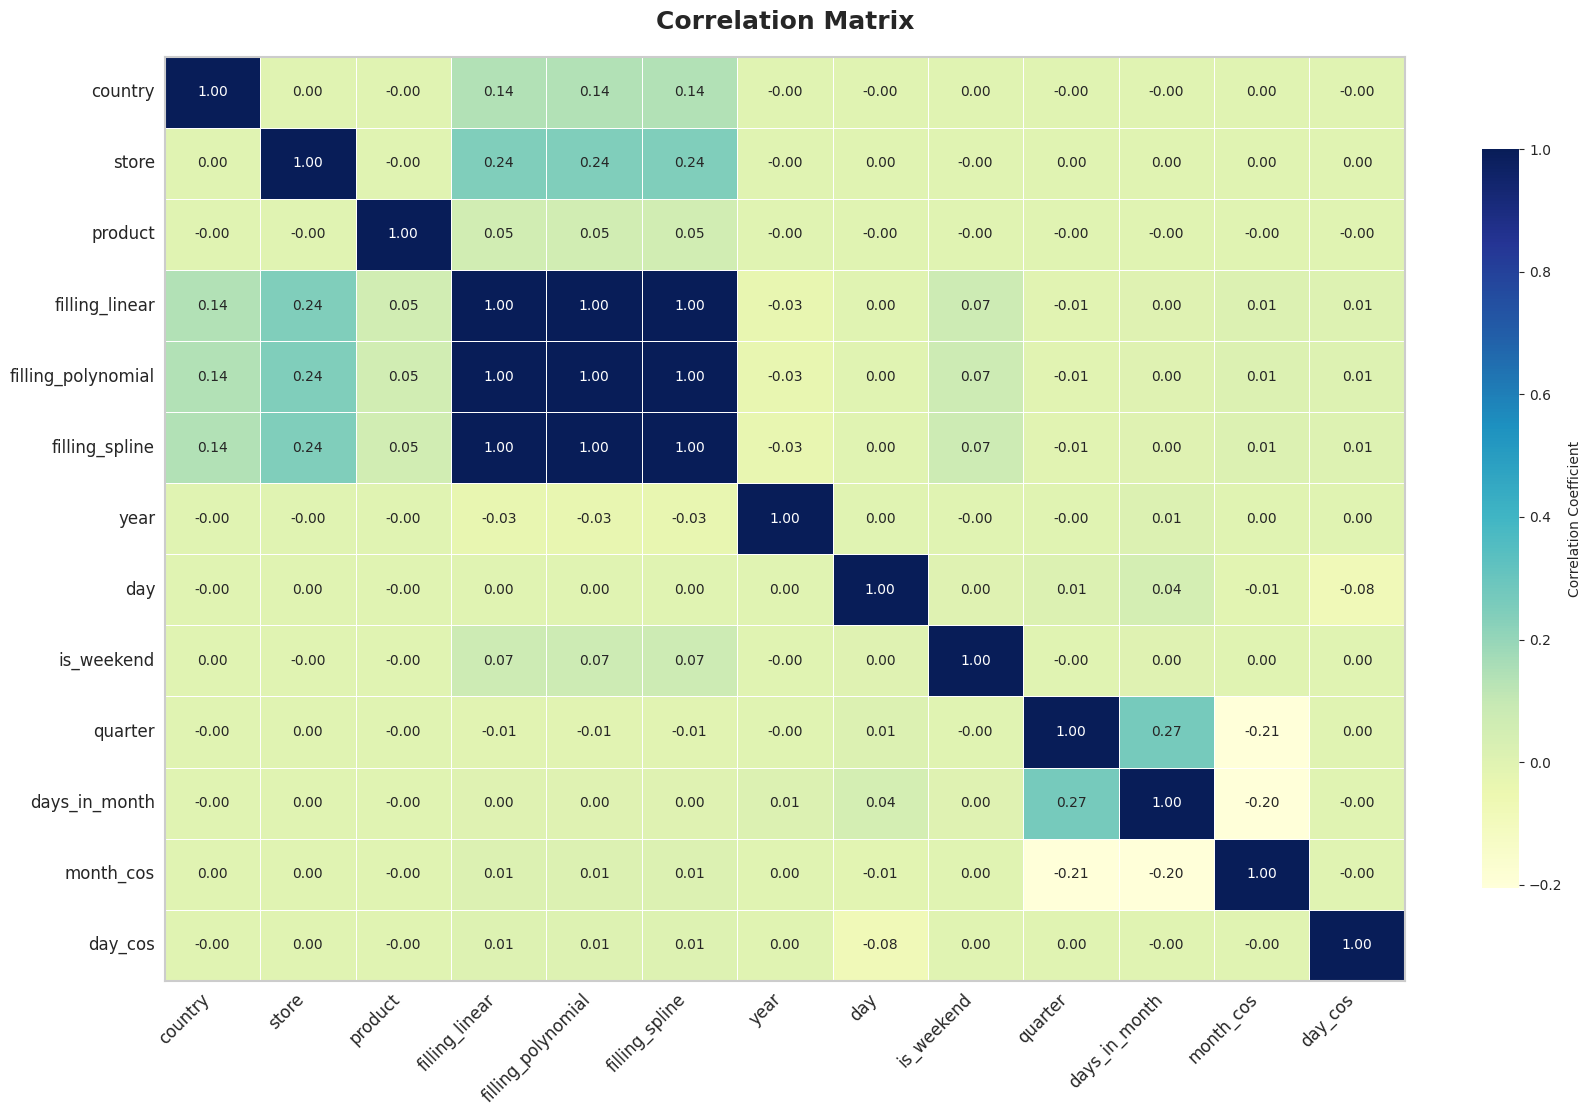

In [117]:
matrix = df.corr()

plt.figure(figsize=(20, 12))
sns.set_style("whitegrid")
ax = sns.heatmap(
    matrix, 
    cmap="YlGnBu",
    annot=True, 
    fmt=".2f", 
    linewidths=0.7, 
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)

plt.title("Correlation Matrix", fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

ax.set_facecolor('white')
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.show()

We can observe that some of the newly created columns, such as the 'filling_' columns, exhibit linear correlation coefficients. However, the correlation values for these features are not higher than 0.3. This indicates that, although there is some relationship, the strength of the correlation is relatively weak. A correlation coefficient below 0.3 generally suggests that these features have little to no linear relationship with the target variable. This could be due to various factors, such as the nature of the data or the method used for imputation, which may not capture complex patterns in the data.

# Training

In [118]:
# Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Generate sequence
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

def prepare_data(df, target_column, window_size=7):
    df[target_column] = np.log1p(df[target_column])
    split_idx = int(len(df) * 0.8)
    train_df, test_df = df.iloc[:split_idx], df.iloc[split_idx - window_size:]

    feature_columns = [col for col in df.columns if col != target_column]
    feature_scaler = MinMaxScaler()
    
    X_train = feature_scaler.fit_transform(train_df[feature_columns])
    y_train = train_df[target_column].values.flatten()
    X_test = feature_scaler.transform(test_df[feature_columns])
    y_test = test_df[target_column].values.flatten()

    joblib.dump(feature_scaler, './results/feature_scaler.pkl')

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

    return X_train_seq, X_test_seq, y_train_seq, y_test_seq

In [119]:
get_target = df[['filling_linear', 'filling_polynomial', 'filling_spline']]
df = df.drop(columns=['filling_linear', 'filling_polynomial', 'filling_spline'])

df_linear = df.assign(filling_linear=get_target['filling_linear'])
df_polynomial = df.assign(filling_polynomial=get_target['filling_polynomial'])
df_spline = df.assign(filling_spline=get_target['filling_spline'])

In [120]:
def train_and_evaluate_xgboost(df, target_column, rounds=20):
    """
    Train an XGBoost regression model and evaluate its performance using multiple metrics.
    Returns:
        list: List of tuples with metric names and values
    """
    df = df.copy()

    y = df[target_column]
    X = df.drop(columns=[target_column])

    train_size = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=rounds, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Вычисляем все метрики
    metrics = [
        ("MSE", mean_squared_error(y_test, y_pred)),
        ("RMSE", np.sqrt(mean_squared_error(y_test, y_pred))),
        ("MAE", mean_absolute_error(y_test, y_pred)),
        ("MAPE", mean_absolute_percentage_error(y_test, y_pred)),
        ("SMAPE", smape(y_test, y_pred))
    ]
    
    return metrics  # Возвращаем список метрик

def print_results(rmse_linear, rmse_polynomial, rmse_spline):
    """Выводит результаты в виде структурированных таблиц"""
    metrics_data = []
    # Исправляем названия переменных для ясности
    for dataset_name, metrics in [("Linear", rmse_linear),
                                  ("Polynomial", rmse_polynomial),
                                  ("Spline", rmse_spline)]:
        row = [dataset_name]
        for metric_name, value in metrics:
            if metric_name in ["MAPE", "SMAPE"]:
                row.append(f"{value:.2f}%")
            else:
                row.append(f"{value:.2f}")
        metrics_data.append(row)

    headers = ["Dataset", "MSE", "RMSE", "MAE", "MAPE", "SMAPE"]
    print("\n📊 Model Performance Comparison:")
    print(tabulate(
        metrics_data,
        headers=headers,
        tablefmt="fancy_grid"
    ))

# Пример использования
rmse_linear = train_and_evaluate_xgboost(df_linear, 'filling_linear')
rmse_polynomial = train_and_evaluate_xgboost(df_polynomial, 'filling_polynomial')
rmse_spline = train_and_evaluate_xgboost(df_spline, 'filling_spline')

print_results(rmse_linear, rmse_polynomial, rmse_spline)


📊 Model Performance Comparison:
╒════════════╤═════════╤════════╤═══════╤════════╤═════════╕
│ Dataset    │     MSE │   RMSE │   MAE │ MAPE   │ SMAPE   │
╞════════════╪═════════╪════════╪═══════╪════════╪═════════╡
│ Linear     │ 10073.4 │ 100.37 │ 59.34 │ 26.71% │ 24.42%  │
├────────────┼─────────┼────────┼───────┼────────┼─────────┤
│ Polynomial │ 10408.2 │ 102.02 │ 61.67 │ 31.38% │ 27.76%  │
├────────────┼─────────┼────────┼───────┼────────┼─────────┤
│ Spline     │ 10816.6 │ 104    │ 61.44 │ 25.50% │ 23.62%  │
╘════════════╧═════════╧════════╧═══════╧════════╧═════════╛


As a result we find that linear is the best choice for distribution and because of it I will use another model for better performance. Setting all in 32 bytes to speed up train process.

In [121]:
df_linear = df_linear.astype({
    "country": "int32",
    "store": "int32",
    "product": "int32",
    "year": "int32",
    "day": "int32",
    "is_weekend": "int32",
    "quarter": "int32",
    "days_in_month": "int32",
    "month_cos": "float32",
    "day_cos": "float32",
    "filling_linear": "float32"
})

In [122]:
# Model LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, _ = self.lstm(x)
        output = self.dropout(output[:, -1, :])
        return self.fc(output)

# Params
num_layers = 6
window_size = 7
hidden_size = 512
batch_size = 32
epochs = 100
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
X_train, X_test, y_train, y_test = prepare_data(df_linear, "filling_linear", window_size)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Train 
model = LSTMModel(
    input_size=X_train.shape[-1],
    hidden_size=hidden_size,
    num_layers=num_layers
).to(device)

criterion = nn.HuberLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=patience,
    min_lr=1e-6
)

best_loss = float('inf')
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': []}
progress_bar = tqdm(range(epochs), desc="Training process")

for epoch in progress_bar:
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch.to(device))
        loss = criterion(outputs, y_batch.to(device).unsqueeze(1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            outputs = model(X_val.to(device))
            val_loss += criterion(outputs, y_val.to(device).unsqueeze(1)).item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    progress_bar.set_postfix({'Train Loss': f"{avg_train_loss:.4f}", 'Val Loss': f"{avg_val_loss:.4f}"})

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./results/best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    scheduler.step(avg_val_loss)

# Inference
def predict(model_path, test_loader):
    """Функция предсказания"""
    model = LSTMModel(
        input_size=X_train.shape[-1],
        hidden_size=hidden_size,
        num_layers=num_layers
    ).to(device)
    
    model.load_state_dict(torch.load(model_path))
    model.eval()

    predictions = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            outputs = model(X_batch.to(device)).cpu().numpy()
            predictions.append(outputs)

    return np.concatenate(predictions).flatten()

y_pred = np.round(np.expm1(predict("./results/best_model.pth", test_loader)))
y_true = np.round(np.expm1(y_test))

Training process:  61%|██████    | 61/100 [1:16:27<48:52, 75.21s/it, Train Loss=0.0058, Val Loss=0.0048]  



Early stopping at epoch 62


In [123]:
metrics = [
    ("MSE", mean_squared_error(y_true, y_pred)),
    ("RMSE", np.sqrt(mean_squared_error(y_true, y_pred))),
    ("MAE", mean_absolute_error(y_true, y_pred)),
    ("MAPE", mean_absolute_percentage_error(y_true, y_pred)),
    ("SMAPE", smape(y_true, y_pred))
]

print("\n" + tabulate(
    [[name, f"{value:.2f}" + ("%" if name in ["MAPE", "SMAPE"] else "")] for name, value in metrics],
    headers=["Metric", "Value"],
    tablefmt="fancy_grid"
))


╒══════════╤═════════╕
│ Metric   │ Value   │
╞══════════╪═════════╡
│ MSE      │ 7697.75 │
├──────────┼─────────┤
│ RMSE     │ 87.74   │
├──────────┼─────────┤
│ MAE      │ 50.32   │
├──────────┼─────────┤
│ MAPE     │ 7.35%   │
├──────────┼─────────┤
│ SMAPE    │ 7.44%   │
╘══════════╧═════════╛


Great results! The implementation of the LSTM model reduced the RMSE, from **100.37** to **87.74**, demonstrating remarkable improvement in prediction. This indicates that the Long Short-Term Memory (LSTM) neural network delivered exceptional performance for this task. Visual analysis of the time-series graphs confirms that the actual and predicted values align almost perfectly, further validating the precision of the model.

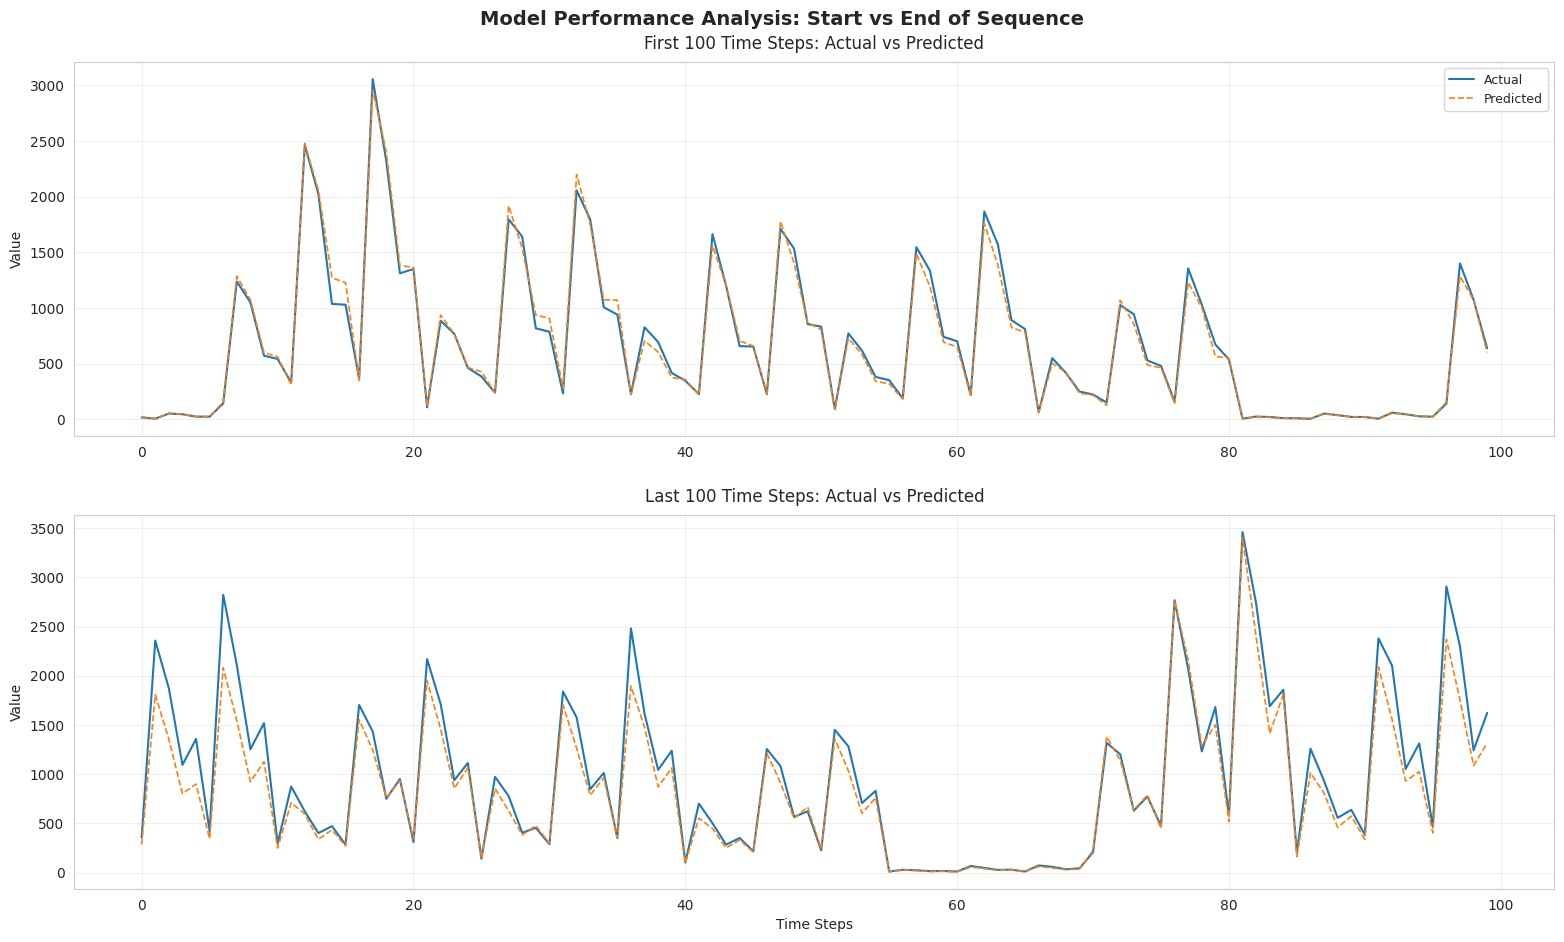

In [124]:
plt.figure(figsize=(16, 10))
# First 100 points
plt.subplot(2, 1, 1)
plt.plot(y_true[:100], label="Actual", color="#1f77b4", linewidth=1.5)
plt.plot(y_pred[:100], label="Predicted", color="#ff7f0e", linestyle="--", linewidth=1.2)
plt.title("First 100 Time Steps: Actual vs Predicted", fontsize=12, pad=10)
plt.ylabel("Value", fontsize=10)
plt.grid(alpha=0.3)
plt.legend(loc='upper right', fontsize=9)

# Last 100 points
plt.subplot(2, 1, 2)
plt.plot(y_true[-100:], label="Actual", color="#1f77b4", linewidth=1.5)
plt.plot(y_pred[-100:], label="Predicted", color="#ff7f0e", linestyle="--", linewidth=1.2)
plt.title("Last 100 Time Steps: Actual vs Predicted", fontsize=12, pad=10)
plt.xlabel("Time Steps", fontsize=10)
plt.ylabel("Value", fontsize=10)
plt.grid(alpha=0.3)

# Common settings
plt.suptitle("Model Performance Analysis: Start vs End of Sequence", 
             fontsize=14, 
             y=0.95,
             weight='semibold')
plt.tight_layout(pad=2.0)
plt.show()

 Given these outcomes, I will proceed with submitting the final predictions for evaluation.

In [126]:
def create_inference_sequences(data: np.ndarray, window_size: int):
    """Creates sequences for inference based on the given window size."""
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i : i + window_size])
    return np.array(sequences)

final_df = pd.read_csv("./data/test.csv")
original_ids = final_df["id"].values

final_df = add_time_features(final_df)
final_df.drop(columns=["id", "date", "day_of_week"], inplace=True)
final_df = encode_categorical_features(final_df, categorical_columns)
feature_scaler = joblib.load("./results/feature_scaler.pkl")
X_inference = feature_scaler.transform(final_df).astype(np.float32)
X_inference_seq = create_inference_sequences(X_inference, window_size)
inference_tensor = torch.tensor(X_inference_seq, dtype=torch.float32)
inference_loader = DataLoader(TensorDataset(inference_tensor), batch_size=64, shuffle=False)

# Train process
model = LSTMModel(
    input_size=X_train.shape[-1],
    hidden_size=hidden_size,
    num_layers=num_layers
).to(device)

model.load_state_dict(torch.load("./results/best_model.pth"))
model.eval()

results = []
with torch.no_grad():
    for X_batch in tqdm(inference_loader):
        X_input = X_batch[0].to(device)
        outputs = np.round(np.expm1(model(X_input).cpu().numpy()))
        results.extend(outputs.flatten())

# Get first n points with median
median_value = np.round(np.median(results))
full_results = np.concatenate([
    np.full(shape=window_size-1, fill_value=median_value),
    np.array(results)
])

# Concate with IDs
submit_ids = original_ids[:len(full_results)] 
pd.DataFrame({"id": submit_ids, "num_sold": full_results}).to_csv("./results/submit.csv", index=False)
print("✅ Prediction file 'submit.csv' has been successfully saved!")

100%|██████████| 1540/1540 [00:04<00:00, 341.67it/s]


✅ Prediction file 'submit.csv' has been successfully saved!
